In [1]:
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
import cartopy.crs as ccrs
import glob

import torch
from torch.utils.data import Dataset
import numpy as np
import xarray as xr
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache
from torch.utils.data import Dataset, DataLoader


import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.nn import Module, ModuleList
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam

from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

from denoising_diffusion_pytorch.attend import Attend
import requests
import random
from denoising_diffusion_pytorch.version import __version__
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import pickle

In [2]:
models = sorted([I for I in glob.glob('/glade/work/timothyh/Diffusion/Forecasting/denoising-diffusion-pytorch/results/*.pt')])

models[-1]

'/glade/work/timothyh/Diffusion/Forecasting/denoising-diffusion-pytorch/results/model-9.pt'

In [2]:
mean = 152.16729736328125
std = 147.735107421875
maxivt = 15.220598
minivt = -1.0300009
data = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_0/train.nc').forecast.sel(time=slice(1,5))
data = (data-mean)/std
data = (data-minivt)/(maxivt-minivt)
data.shape

(5, 128, 128)

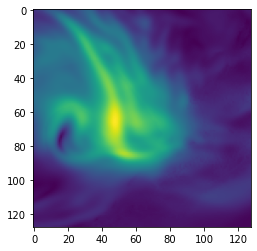

In [3]:
plt.imshow(data[2,:,:])

## GPU

In [4]:
""
gpu_id=0
""
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    
if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB


## Train on Atmospheric rivers

In [3]:
ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

class DataProcessed(Dataset):
    def __init__(self, file_paths, config, mean = 152.16729736328125, std = 147.735107421875, maxivt = 15.220598, minivt = -1.0300009):
        """
        Args:
            file_paths: List of paths to netCDF files
            config: Configuration dict with scaling and augmentation options
        """
        self.file_paths = file_paths
        self.config = config
        self.mean = mean
        self.std = std
        self.minivt = minivt
        self.maxivt = maxivt
        self.augmentation = config.get('augment', False)
        self.scaler = None
        if config['scaling'] == 'quantile':
            self.scaler = QuantileTransformer()

         # Initialize cache size (you can adjust it depending on memory constraints)
        self.cache_size = config.get('cache_size', 10)
        self.cached_data = {}  # Manual cache for storing loaded data

    def __len__(self):
        # Calculate total number of samples across all files
        total_len = 0
        for path in self.file_paths:
            with xr.open_dataset(path) as ds:
                total_len += ds.sizes['time']  # Assuming 'time' is the main dimension
        return total_len

    def _apply_scaling(self, data):
        if self.config['scaling'] == 'quantile':
            data_t = self.scaler.fit_transform(data.reshape(-1, 1)).reshape(data.shape)
        elif self.config['scaling'] == 'std':
            data_t = (data - self.mean) / self.std
            self.config['mean'], self.config['std'] = self.mean, self.std
        else:
            raise ValueError("Invalid scaling method specified.")

        data_t = (data_t - self.minivt) / (self.maxivt - self.minivt)
        return data_t

    def _augment_data(self, data):
        # Apply rotations for augmentation
        data_rot90 = np.rot90(data, k=1, axes=(1, 2))
        data_rot180 = np.rot90(data, k=2, axes=(1, 2))
        data_rot270 = np.rot90(data, k=3, axes=(1, 2))

        
        # Concatenate all rotations along the first dimension (time)
        return np.concatenate([data, data_rot90, data_rot180, data_rot270],axis=0)
    @lru_cache(maxsize=2)  # Cache up to 5 file loads at once
    def _load_data_from_file(self, file_path):
        with xr.open_dataset(file_path) as ds:
            dataX = ds.forecast.values  # Replace 'forecast' with the relevant key in your dataset
            datay = ds.analysis.values
            # Apply scaling
            dataX = self._apply_scaling(dataX)
            datay = self._apply_scaling(datay)
            # Apply augmentation if necessary
            if self.augmentation:
                dataX = self._augment_data(dataX)
                datay = self._augment_data(datay)

        return torch.tensor(dataX, dtype=torch.float32),torch.tensor(datay, dtype=torch.float32)

    def __getitem__(self, idx):
        """
        Load data lazily and cache it, based on global index.
        """
        # Determine which file and sample this index belongs to
        cumulative_len = 0
        for file_idx, path in enumerate(self.file_paths):
            with xr.open_dataset(path) as ds:
                file_len = ds.sizes['time']  # Length along the 'time' dimension
                if cumulative_len + file_len > idx:
                    sample_idx = idx - cumulative_len
                    dataX,datay = self._load_data_from_file(path)  # Load data from cache or disk
                    return dataX[sample_idx],datay[sample_idx]
                cumulative_len += file_len

        raise IndexError(f"Index {idx} is out of bounds")

In [4]:

def get_config():
    config = {
        "input_channels": 1,
        "output_channels": 1,
        "context_image": True,
        "context_channels": 1,
        "num_blocks": [2, 2],
        "hidden_channels": 32,
        "hidden_context_channels": 8,
        "time_embedding_dim": 256,
        "image_size": 128,
        "noise_sampling_coeff": 0.85,
        "denoise_time": 970,
        "activation": "gelu",
        "norm": True,
        "subsample": 100000,
        "save_name": "model_weights.pt",
        "dim_mults": [4, 4],
        "base_dim": 32,
        "timesteps": 1000,
        "pading": "reflect",
        "scaling": "std",
        "optimization": {
            "epochs": 400,
            "lr": 0.01,
            "wd": 0.05,
            "batch_size": 32,
            "scheduler": True
        }
    }
    return config

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original ddpm paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    better for images > 64x64, when used during training
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

class GaussianDiffusion_AR(Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_v',
        beta_schedule = 'sigmoid',
        schedule_fn_kwargs = dict(),
        ddim_sampling_eta = 0.,
        auto_normalize = True,
        offset_noise_strength = 0.,  # https://www.crosslabs.org/blog/diffusion-with-offset-noise
        min_snr_loss_weight = False, # https://arxiv.org/abs/2303.09556
        min_snr_gamma = 5,
        immiscible = False
    ):
        super().__init__()
        assert not (type(self) == GaussianDiffusion and model.channels != model.out_dim)
        assert not hasattr(model, 'random_or_learned_sinusoidal_cond') or not model.random_or_learned_sinusoidal_cond

        self.model = model

        self.channels = self.model.channels
        self.self_condition = self.model.self_condition
        self.condition = self.model.condition

        if isinstance(image_size, int):
            image_size = (image_size, image_size)
        assert isinstance(image_size, (tuple, list)) and len(image_size) == 2, 'image size must be a integer or a tuple/list of two integers'
        self.image_size = image_size

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            beta_schedule_fn = linear_beta_schedule
        elif beta_schedule == 'cosine':
            beta_schedule_fn = cosine_beta_schedule
        elif beta_schedule == 'sigmoid':
            beta_schedule_fn = sigmoid_beta_schedule
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        betas = beta_schedule_fn(timesteps, **schedule_fn_kwargs)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # immiscible diffusion

        self.immiscible = immiscible

        # offset noise strength - in blogpost, they claimed 0.1 was ideal

        self.offset_noise_strength = offset_noise_strength

        # derive loss weight
        # snr - signal noise ratio

        snr = alphas_cumprod / (1 - alphas_cumprod)

        # https://arxiv.org/abs/2303.09556

        maybe_clipped_snr = snr.clone()
        if min_snr_loss_weight:
            maybe_clipped_snr.clamp_(max = min_snr_gamma)

        if objective == 'pred_noise':
            register_buffer('loss_weight', maybe_clipped_snr / snr)
        elif objective == 'pred_x0':
            register_buffer('loss_weight', maybe_clipped_snr)
        elif objective == 'pred_v':
            register_buffer('loss_weight', maybe_clipped_snr / (snr + 1))

        # auto-normalization of data [0, 1] -> [-1, 1] - can turn off by setting it to be False

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    @property
    def device(self):
        return self.betas.device

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, x_self_cond = None, x_cond = None, clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t, x_self_cond, x_cond)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, x_self_cond = None, x_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, x_self_cond, x_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.inference_mode()
    def p_sample(self, x, t: int, x_self_cond = None, x_cond = None):
        b, *_, device = *x.shape, self.device
        batched_times = torch.full((b,), t, device = device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = True)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.inference_mode()
    def p_sample_loop(self, shape, x_cond, return_all_timesteps = False):
        batch, device = shape[0], self.device

        img = torch.randn(shape, device = device)
        imgs = [img]

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, t, self_cond, x_cond)
            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret

    @torch.inference_mode()
    def ddim_sample(self, shape, x_cond, return_all_timesteps = False):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)
        imgs = [img]

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device = device, dtype = torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, x_cond, clip_x_start = True, rederive_pred_noise = True)

            if time_next < 0:
                img = x_start
                imgs.append(img)
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret

    @torch.inference_mode()
    def sample(self, x_cond, batch_size = 16, return_all_timesteps = False):
        (h, w), channels = self.image_size, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, channels, h, w), x_cond, return_all_timesteps = return_all_timesteps)

    @torch.inference_mode()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.full((b,), t, device = device)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2

        x_start = None

        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            self_cond = x_start if self.self_condition else None
            x_cond = x_cond if self.condition else None
            img, x_start = self.p_sample(img, i, self_cond, x_cond)

        return img

    def noise_assignment(self, x_start, noise):
        x_start, noise = tuple(rearrange(t, 'b ... -> b (...)') for t in (x_start, noise))
        dist = torch.cdist(x_start, noise)
        _, assign = linear_sum_assignment(dist.cpu())
        return torch.from_numpy(assign).to(dist.device)

    @autocast('cuda', enabled = False)
    def q_sample(self, x_start, t, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        if self.immiscible:
            assign = self.noise_assignment(x_start, noise)
            noise = noise[assign]

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, x_cond, noise = None, offset_noise_strength = None):
        b, c, h, w = x_start.shape

        noise = default(noise, lambda: torch.randn_like(x_start))

        # offset noise - https://www.crosslabs.org/blog/diffusion-with-offset-noise

        offset_noise_strength = default(offset_noise_strength, self.offset_noise_strength)

        if offset_noise_strength > 0.:
            offset_noise = torch.randn(x_start.shape[:2], device = self.device)
            noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond, x_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, x_cond, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size[0] and w == img_size[1], f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, x_cond, *args, **kwargs)

class Trainer_ARs:
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        augment_horizontal_flip = True,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 1000,
        num_samples = 25,
        results_folder = './results',
        amp = False,
        mixed_precision_type = 'fp16',
        split_batches = True,
        convert_image_to = None,
        calculate_fid = True,
        inception_block_idx = 2048,
        max_grad_norm = 1.,
        num_fid_samples = 50000,
        save_best_and_latest_only = False
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = mixed_precision_type if amp else 'no'
        )

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels
        is_ddim_sampling = diffusion_model.is_ddim_sampling

        # default convert_image_to depending on channels

        if not exists(convert_image_to):
            convert_image_to = {1: 'L', 3: 'RGB', 4: 'RGBA'}.get(self.channels)

        # sampling and training hyperparameters

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every
        assert (train_batch_size * gradient_accumulate_every) >= 16, f'your effective batch size (train_batch_size x gradient_accumulate_every) should be at least 16 or above'

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        self.max_grad_norm = max_grad_norm

        # dataset and dataloader
        config = get_config()
        FPs = sorted(glob.glob(f'/{folder}/*train.nc'))
        print(FPs)
        self.ds = DataProcessed(FPs, config)
        print(self.ds)
        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)

        # FID-score computation

        self.calculate_fid = calculate_fid and self.accelerator.is_main_process

        if self.calculate_fid:
            from denoising_diffusion_pytorch.fid_evaluation import FIDEvaluation

            if not is_ddim_sampling:
                self.accelerator.print(
                    "WARNING: Robust FID computation requires a lot of generated samples and can therefore be very time consuming."\
                    "Consider using DDIM sampling to save time."
                )

            self.fid_scorer = FIDEvaluation(
                batch_size=self.batch_size,
                dl=self.dl,
                sampler=self.ema.ema_model,
                channels=self.channels,
                accelerator=self.accelerator,
                stats_dir=results_folder,
                device=self.device,
                num_fid_samples=num_fid_samples,
                inception_block_idx=inception_block_idx
            )

        if save_best_and_latest_only:
            assert calculate_fid, "`calculate_fid` must be True to provide a means for model evaluation for `save_best_and_latest_only`."
            self.best_fid = 1e10 # infinite

        self.save_best_and_latest_only = save_best_and_latest_only

    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
            'version': __version__
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, milestone):
        accelerator = self.accelerator
        device = accelerator.device

        data = torch.load(str(self.results_folder / f'model-{milestone}.pt'), map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        if 'version' in data:
            print(f"loading from version {data['version']}")

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device
        x_cond_rand = torch.zeros(60,1,128,128)
        data, x_c = self.ds.__getitem__(0)
        data = data.to(device).unsqueeze(1)
        x_c = x_c.to(device).unsqueeze(1)
        num_gpus = accelerator.num_processes
        
        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:
                self.model.train()

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data, x_cond = next(self.dl)
                    data = data.to(device).unsqueeze(1)
                    x_cond = x_cond.to(device).unsqueeze(1)
                    go_in = torch.randint(0, 100, (1,)).item()  # Index for x_cond_rand
                    if go_in < 30:
                        idx_rand1 = torch.randint(0, 59, (1,)).item()  # Index for x_cond_rand
                        idx_rand2 = torch.randint(0, int(x_cond.shape[0]), (1,)).item()  # Index for x_cond
                        x_cond_rand[idx_rand1, 0, :, :] = x_cond[idx_rand2, 0, :, :].clone()
                        
                    with self.accelerator.autocast():
                        loss = self.model(data, x_cond)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()
                accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and divisible_by(self.step, self.save_and_sample_every):
                        self.ema.ema_model.eval()

                        with torch.inference_mode():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            x_cond_rand = x_cond_rand.to(device)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n, x_cond = x_cond_rand[:n,:,:,:]), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))

                        # whether to calculate fid

                        if self.calculate_fid:
                            fid_score = self.fid_scorer.fid_score()
                            accelerator.print(f'fid_score: {fid_score}')

                        if self.save_best_and_latest_only:
                            if self.best_fid > fid_score:
                                self.best_fid = fid_score
                                self.save("best")
                            self.save("latest")
                        else:
                            self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')

def exists(x):
    return x is not None
def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def cycle(dl):
    while True:
        for data in dl:
            yield data

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cast_tuple(t, length = 1):
    if isinstance(t, tuple):
        return t
    return ((t,) * length)

def divisible_by(numer, denom):
    return (numer % denom) == 0

def identity(t, *args, **kwargs):
    return t

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5
def transform_sampled_images(sampled_images, trainer):
    minivt = trainer.ds.minivt
    maxivt = trainer.ds.maxivt
    meanivt = trainer.ds.mean
    stdivt = trainer.ds.std

    # Perform the transformation
    sampled_images_t = (sampled_images.cpu().numpy() * (maxivt - minivt)) + minivt
    sampled_images_t = (sampled_images_t * stdivt) + meanivt

    return sampled_images_t
    
# small helper modules


In [5]:
model = Unet(
    channels = 1,
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion_AR(
    model,
    image_size = (128, 128),
    timesteps = 1000,    # number of steps
    auto_normalize = True,
    objective = "pred_v",
)
diffusion.is_ddim_sampling = True

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [12]:
trainer = Trainer_ARs(
    diffusion,
    '/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_0/',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 300,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False,           # whether to calculate fid during training
    max_grad_norm = 1.0,
)

['//glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_0/train.nc']


In [13]:
trainer.train()

  0%|          | 0/300 [00:00<?, ?it/s]

training complete


In [14]:
data = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_0/train.nc').forecast.sel(time=slice(1,5))
X = torch.tensor(data.values).to(device).unsqueeze(1)
sampled_images = diffusion.sample(X, batch_size = 5, return_all_timesteps = False)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
sampled_images_t = transform_sampled_images(sampled_images, trainer)

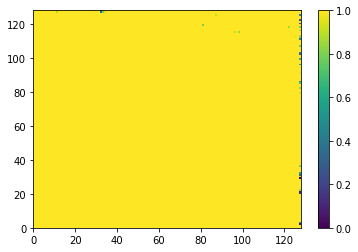

In [15]:
plt.pcolor(sampled_images.detach().cpu().numpy().squeeze()[1,:,:])
plt.colorbar()
plt.show()

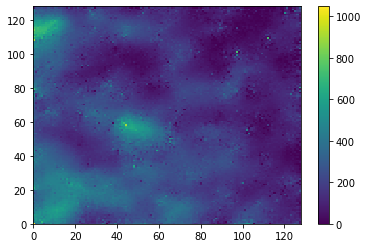

In [13]:
plt.pcolor(sampled_images_t.squeeze()[4,:,:])
plt.colorbar()
plt.show()

In [5]:
data = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/processed/lead_0/train.nc').forecast.sel(time=slice(1,5))
X = torch.tensor(data.values).to(device).unsqueeze(1)

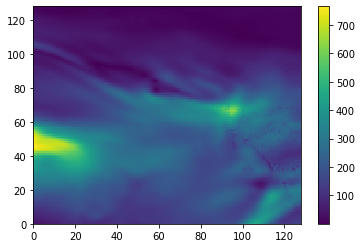

In [6]:
plt.pcolor(X.detach().cpu().numpy().squeeze()[1,:,:])
plt.colorbar()
plt.show()

In [ ]:
DSvars = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_9/test/F009_WY_1999_500mb.nc')
DSvars = DSvars['IVT'][:,13:,13:]
lat = DSvars['lat']
lon = DSvars['lon']

In [ ]:
nummy = 1
vmini = 0 
vmaxi= 560

fig, axes = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotting the first data set on the map
im1 = axes.pcolor(lon, lat, sampled_images_t.squeeze()[ii,:,:], cmap='RdBu', vmin=vmini, vmax=vmaxi, transform=ccrs.PlateCarree())
axes.coastlines()
axes.set_title('AR Gen')
cbar1 = plt.colorbar(im1, ax=axes, orientation='horizontal', pad=0.05, aspect=40,)
cbar1.set_label('kg m${-1}$ s${-1}$')


# Formatting latitude and longitude
axes.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())  # Set extent to regional model bounds
axes.set_xticks(np.arange(lon.min(), lon.max(), 5), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(lat.min(), lat.max(), 5), crs=ccrs.PlateCarree())
axes.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}°'))
axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}°'))

plt.tight_layout()
# plt.savefig(f'./GIF/image_{ii:06}.png', bbox_inches=None, dpi=100)
plt.show()

## Renormalize and Plot

In [140]:
DSvars = xr.open_dataset('/glade/derecho/scratch/timothyh/data/diffusion_forecasts/preprocessed/lead_9/test/F009_WY_1999_500mb.nc')
DSvars = DSvars['IVT'][:,13:,13:]
lat = DSvars['lat']
lon = DSvars['lon']

## ReNormalize

In [105]:
def transform_sampled_images(sampled_images, trainer):
    minivt = trainer.ds.minivt
    maxivt = trainer.ds.maxivt
    meanivt = trainer.ds.mean
    stdivt = trainer.ds.std

    # Perform the transformation
    sampled_images_t = (sampled_images.cpu().numpy() * (maxivt - minivt)) + minivt
    sampled_images_t = (sampled_images_t * stdivt) + meanivt

    return sampled_images_t
    
sampled_images_t = transform_sampled_images(sampled_images, trainer)

In [122]:
sampled_images_t.squeeze()[0,700,:,:]


for ii in range(700,1001):
    nummy = 1
    vmini = 0 
    vmaxi= 560
    
    fig, axes = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plotting the first data set on the map
    im1 = axes.pcolor(lon, lat, sampled_images_t.squeeze()[0,ii,:,:], cmap='RdBu', vmin=vmini, vmax=vmaxi, transform=ccrs.PlateCarree())
    axes.coastlines()
    axes.set_title('AR Gen')
    cbar1 = plt.colorbar(im1, ax=axes, orientation='horizontal', pad=0.05, aspect=40,)
    cbar1.set_label('kg m${-1}$ s${-1}$')
    
    
    # Formatting latitude and longitude
    axes.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())  # Set extent to regional model bounds
    axes.set_xticks(np.arange(lon.min(), lon.max(), 5), crs=ccrs.PlateCarree())
    axes.set_yticks(np.arange(lat.min(), lat.max(), 5), crs=ccrs.PlateCarree())
    axes.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}°'))
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}°'))
    
    plt.tight_layout()
    plt.savefig(f'./GIF/image_{ii:06}.png', bbox_inches=None, dpi=100)
    plt.close()

In [123]:
import imageio
import os

def create_gif(image_folder, gif_name, duration=0.2):
    """
    Create a GIF from a series of images.
    
    Parameters:
        image_folder (str): The path to the folder containing the images.
        gif_name (str): The name of the output GIF file.
        duration (float): The duration between frames in seconds.
    """
    images = []
    
    # Get all image files from the folder, sorted in numerical order
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    
    # Save images as a gif
    gif_path = os.path.join(image_folder, gif_name)
    imageio.mimsave(gif_path, images, duration=duration)

    print(f"GIF saved as {gif_path}")

# Example usage:
create_gif('./GIF', 'AR_GEN.gif', duration=0.2)


ModuleNotFoundError: No module named 'imageio'

In [41]:
taco = trainer.ema.ema_model.sample(batch_size=16)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

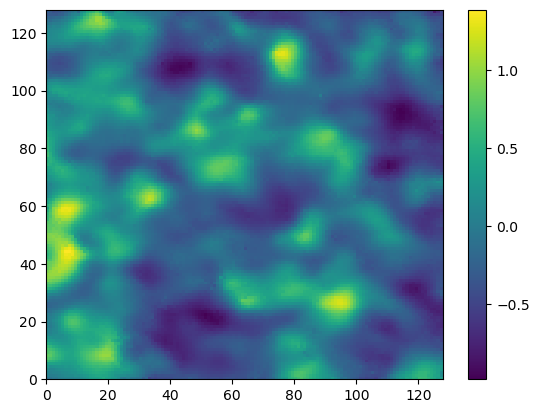

In [48]:
plt.pcolor(taco[12,0,:,:].cpu().numpy())
plt.colorbar()

In [22]:
diffusion.is_ddim_sampling

True

In [22]:
import matplotlib.pyplot as plt

In [29]:
data = next(trainer.dl).to('cpu')

In [33]:
data.unsqueeze(1).shape

torch.Size([32, 1, 128, 128])